<a href="https://colab.research.google.com/github/neutro-jina/project__petfinder/blob/main/%EC%98%A4%EC%98%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import sys
sys.path.append('/content/swin_test/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('/content/swin_test/earlystoppingpytorch/early-stopping-pytorch')

In [64]:
# Import libraries

#!pip install path
#!pip install timm

import numpy as np
import pandas as pd
import os
import path
import random
import cv2
import timm
import gc
import albumentations
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [66]:
# Import PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

#import EarlyStopping
#from pytorchtools import EarlyStopping

from torch.utils.data import DataLoader

In [67]:
# Import SKlearn Libraries
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

# Deciding the device used for calculation. CUDA = GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [68]:
#from zipfile import ZipFile

#with ZipFile("/content/drive/MyDrive/Colab Notebooks/petfinder-pawpularity-score.zip", 'r') as zip:
#    zip.extractall('swin_test')
#    print('file is unzipped in swin_test folder')

In [69]:
data_df = pd.read_csv("/content/swin_test/train.csv")
test_df = pd.read_csv("/content/swin_test/test.csv")

In [70]:
data_train = pd.read_csv("/content/swin_test/train.csv")
data_train

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [71]:
target = ['Pawpularity']
not_features = ['Id', 'kfold', 'image_path', 'Pawpularity']
cols = list(data_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']


In [89]:
params = {
    'folder_dir': '/content/swin_test/',
    'model':'swin_large_patch4_window12_384',
    'image_dir':  '/content/swin_test/train/',
    'test_img_dir': '/content/swin_test/test/',
    'features': features,
    'img_size' : 384,
    'dropout':0.4,
    'num_workers':2,
    'fold' : 10,
    'batch_size' : 4,
    'lr' : 1e-5,
    'scheduler_name': 'CosineAnnealingWarmRestarts',
    'T_0':50,
    'min_lr':1e-7,
    'pretrained':True,
    'weight_decay':1e-6
}

# Setting manual seed to everything.
# So that we will get the same results everything we run the notebook.
SEED = 42

def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [90]:
class PawDataSet():
    def __init__(self,dataset, params, features, transform = None,):
        self.dataset = dataset
        self.image_path = dataset['Id'].apply(lambda x: os.path.join(params['image_dir'],f'{x}.jpg'))
        self.target_label = dataset['Pawpularity']
        self.features = dataset[features].values
        self.class_label = self.target_label/100
        self.transform = transform
        self.params = params
    
    # Returen the len of data.
    def __len__(self):
        return len(self.image_path)
    
    # Load images and target score according to index number (idx)
    def __getitem__(self, idx):
        image_filepath = self.image_path[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        image = np.transpose(image,(2, 0, 1)).astype(np.float32)
        image = torch.tensor(image)
        features = self.features[idx, :]
        targets = torch.tensor(self.class_label[idx]).float()
        
        return image, features, targets

In [91]:
# Augmentation function for the training data.
def Transform_train(DIM = params['img_size']):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=45, p=0.4),
            albumentations.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2,
                val_shift_limit=0.2, p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.5
            )
        ],
        p=1.0
    )

In [92]:
# Augmentation function for the validation data.
def Transform_val(DIM = params['img_size']):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM, DIM),
            albumentations.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p = 1.0
            ),
        ],
        p=1.0
    )

In [93]:
# Using Sturges' rule to determine the best number of bins for our data.
num_bins = int(np.floor(1+np.log2(len(data_df))))

In [94]:
data_df['bins'] = pd.cut(data_df['Pawpularity'], bins=num_bins, labels=False)
data_df['fold'] = -1

# Function to create Folds.
def create_folds(data, num_splits):
    strat_kfold = StratifiedKFold(n_splits=num_splits, random_state=SEED, shuffle=True)
    for i, (_, idx) in enumerate(strat_kfold.split(data_df.index, data_df['bins'])):
        data_df.iloc[idx, -1] = i
    
    data_df['fold'] = data_df['fold'].astype('int')
    data_df.fold.value_counts().plot.bar(xlabel="Fold", ylabel="Number of data")

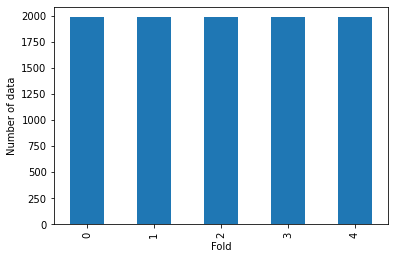

In [95]:
# 5 Folds
df_5 = create_folds(data_df, num_splits=5)

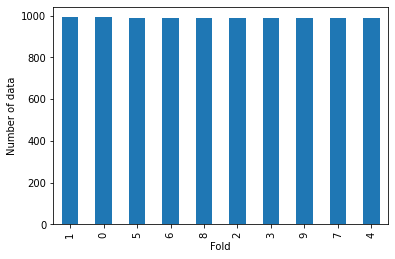

In [96]:
# 10 Folds
df_10 = create_folds(data_df, num_splits=10)

In [97]:
def usr_rmse_score(output, target):
    y_pred = torch.sigmoid(output).cpu()
    y_pred = y_pred.detach().numpy()*100
    target = target.cpu()*100
    
    return mean_squared_error(target, y_pred, squared=False)

In [98]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()
        
    def reset(self):
        self.metrics = defaultdict(lambda: {'val':0, 'count':0, 'avg':0})
    
    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        
        metric['val'] += val
        metric['count'] += 1
        metric['avg'] = metric['val'] / metric['count']
        
    def __str__(self):
        return "|".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric['avg'],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    

In [99]:
def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0 = scheduler_params['T_0'],
            eta_min = scheduler_params['min_lr'],
            last_epoch = -1
        )
    return scheduler

In [100]:
# Load and print out the architecture of the pretrained model.
# We will change only the last layer of the model(head) in the next column.
SWIN_model = timm.create_model(model_name = params['model'])
print(SWIN_model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=192, input_resolution=(96, 96), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
     

In [101]:
class PetNet(nn.Module):
    def __init__(self, model_name=params['model'], pretrained=params['pretrained'], features=len(params['features']) ):
        super().__init__()
        self.model = timm.create_model(model_name=model_name, pretrained=pretrained, in_chans=3)
        # Replace the final head layers in model with our own Linear layer
        num_features = self.model.head.in_features
        self.model.head = nn.Linear(num_features, 128)
        self.fully_connect = nn.Sequential(nn.Linear(128 + features, 64),
                                           nn.ReLU(),
                                           nn.Linear(64, 1)
                                          )
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, image, features):
        x = self.model(image)
        # Using dropout functions to randomly shutdown some of the nodes in hidden layers to prevent overfitting.
        x = self.dropout(x)
        # Concatenate the metadata into the results.
        x = torch.cat([x, features], dim=1)
        output = self.fully_connect(x)
        return output

In [102]:
def train_fn(train_loader, model, criterion, optimizer ,epoch, params, scheduler=None):
    metric_monitor = MetricMonitor()
    # Set the model into train model. There are train mode and eval mode.
    model.train()
    
    # Load the data using tqdm to visualize the training process.
    stream = tqdm(train_loader)
    
    for i, (images,features, target) in enumerate(stream):
        images = images.to(device)
        target = target.to(device).view(-1, 1)
        features = features.to(device)
        
        # Generate predictions by passing images through the model.
        preds = model(images, features)
        
        # Calculate the difference between prediction value and target value ('Pawpularity' label). 
        loss = criterion(preds, target)
        
        # Generate Root Mean Square Error score
        rmse_score = usr_rmse_score(preds, target)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('RMSE', rmse_score)
        
        # Generate loss gradient and optimize the weight of model using optimizer.
        loss.backward()
        optimizer.step()
        
        # Use scheduler to change the learning rate.
        if scheduler is not None:
            scheduler.step()
            
        # Reset the gradient after each loop. To avoid it from adding up.
        optimizer.zero_grad()
        
        # Set description to the progress bar when we run this training function
        stream.set_description(f"Epoch: {epoch:02}. Train. {metric_monitor}")

In [103]:
def validate_fn(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    
    # Set the model into evaluation mode. This will turn off the Dropout layers or BatchNorm layers in the model.
    model.eval()
    stream = tqdm(val_loader)
    valid_targets = []
    predictions = []
    
    # Turn off the gradient tracking for faster processing.
    with torch.no_grad():
        for i, (images,features, target) in enumerate(stream, start=1):
            images = images.to(device)
            target = target.float().view(-1, 1)
            target = target.to(device)
            features = features.to(device)
           
            preds = model(images, features)
            loss = criterion(preds, target)
           
            rmse_score = usr_rmse_score(preds, target)
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('RMSE', rmse_score)
            stream.set_description(f'Epoch: {epoch:02}. Valid. {metric_monitor}')
            
            targets = (target.detach().cpu().numpy()*100).tolist()
            outputs = (torch.sigmoid(preds).detach().cpu().numpy()*100).tolist()
            
            valid_targets.extend(targets)
            predictions.extend(outputs)
            
    return valid_targets, predictions

In [106]:
best_models_of_each_fold = []
rmse_tracker = []

In [108]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [109]:
5# Set the range from 0 to 10 to run the whole Folds.
for fold in range(1):
    # Split the data into training data and validation data for cross validation
    # The data that have same label as the fold will be used as Validation data, the rest as Training data.
    train = data_df[data_df['fold']!=fold].reset_index(drop=True)
    val = data_df[data_df['fold']==fold].reset_index(drop=True)
    
    # Making training and validating dataset.
    train_dataset = PawDataSet(
        dataset = train,
        params = params,
        features = params['features'],
        transform = Transform_train()
    )
    val_dataset = PawDataSet(
        dataset = val,
        params = params,
        features = params['features'],
        transform = Transform_val()
    )
    
    # Making data loader using PyTorch DataLoader function. This allow us to separate data into small batches to train the model.
    train_loader  = DataLoader(
        train_dataset, batch_size=params['batch_size'], shuffle=True, 
        num_workers=params['num_workers']
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=params['batch_size'], shuffle=False,
        num_workers=params['num_workers']
    )
    
    # Loading model into GPU.
    model = PetNet()
    model = model.to(device)
    
    # Setting criterion to calculate loss, optimizer and scheduler.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                 lr=params['lr'],
                                 weight_decay=params['weight_decay'],
                                 amsgrad=False)
    
    # Use the scheduler functions that we defined at section 5.2 to update the learning rate in optimizer.
    scheduler = get_scheduler(optimizer)
    
    # Early stopping functions to stop the training process if the model is not improving after each epoch.
    early_stopping = EarlyStopping(patience=2, verbose=True)
    
    # Training and validation loop
    best_rmse = np.inf
    best_epoch = np.inf
    best_model_name = None
    
    # Epoch = how many times to repeat the training loop.
    for epoch in range(40):
        train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler)
        predictions, valid_targets = validate_fn(val_loader, model, criterion, epoch, params)
        rmse = round(mean_squared_error(valid_targets, predictions, squared=False), 3)
        
        # Condition loop to save the model with best score.
        if rmse < best_rmse:
            best_rmse = rmse
            best_epoch = epoch
            if best_model_name is not None:
                os.remove(best_model_name)
                
            # Saving state_dict of the best model to rerun it later for inference.
            torch.save(model.state_dict(),
                       f"{params['model']}_epoch_f{fold}.pth")
            best_model_name = f"{params['model']}_epoch_f{fold}.pth"
        
        # Evaluate the output rmse of the model to decide whether to stop the loop or not.
        early_stopping(rmse, model)
        
        # Stop the training loop if the score doesn't improve after each epoch.
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # Print summary
    print('')
    print(f'The best RMSE: {best_rmse} for fold {fold+1} was achieved on epoch: {best_epoch}')
    print(f'The best saved model is: {best_model_name}')
    best_models_of_each_fold.append(best_model_name)
    rmse_tracker.append(best_rmse)
    print(''.join(['#']*50))
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
print('')
print(f'Average RMSE of all folds: {round(np.mean(rmse_tracker), 4)}')
    

Epoch: 00. Train. Loss: 0.657|RMSE: 18.045: 100%|██████████| 2230/2230 [34:02<00:00,  1.09it/s]
Epoch: 00. Valid. Loss: 0.646|RMSE: 16.798: 100%|██████████| 248/248 [01:20<00:00,  3.09it/s]


Validation loss decreased (inf --> 18.492000).  Saving model ...


Epoch: 01. Train. Loss: 0.650|RMSE: 17.155: 100%|██████████| 2230/2230 [34:04<00:00,  1.09it/s]
Epoch: 01. Valid. Loss: 0.644|RMSE: 16.449: 100%|██████████| 248/248 [01:20<00:00,  3.10it/s]


Validation loss decreased (18.492000 --> 18.174000).  Saving model ...


Epoch: 02. Train. Loss: 0.647|RMSE: 16.826: 100%|██████████| 2230/2230 [34:05<00:00,  1.09it/s]
Epoch: 02. Valid. Loss: 0.643|RMSE: 16.262: 100%|██████████| 248/248 [01:19<00:00,  3.10it/s]


Validation loss decreased (18.174000 --> 18.066000).  Saving model ...


Epoch: 03. Train. Loss: 0.644|RMSE: 16.343: 100%|██████████| 2230/2230 [34:02<00:00,  1.09it/s]
Epoch: 03. Valid. Loss: 0.644|RMSE: 16.380: 100%|██████████| 248/248 [01:20<00:00,  3.10it/s]


EarlyStopping counter: 1 out of 2


Epoch: 04. Train. Loss: 0.641|RMSE: 15.986: 100%|██████████| 2230/2230 [34:01<00:00,  1.09it/s]
Epoch: 04. Valid. Loss: 0.641|RMSE: 16.044: 100%|██████████| 248/248 [01:20<00:00,  3.10it/s]


Validation loss decreased (18.066000 --> 17.771000).  Saving model ...


Epoch: 05. Train. Loss: 0.640|RMSE: 15.917: 100%|██████████| 2230/2230 [34:04<00:00,  1.09it/s]
Epoch: 05. Valid. Loss: 0.643|RMSE: 16.351: 100%|██████████| 248/248 [01:20<00:00,  3.10it/s]


EarlyStopping counter: 1 out of 2


Epoch: 06. Train. Loss: 0.637|RMSE: 15.644: 100%|██████████| 2230/2230 [34:04<00:00,  1.09it/s]
Epoch: 06. Valid. Loss: 0.642|RMSE: 16.207: 100%|██████████| 248/248 [01:20<00:00,  3.09it/s]


EarlyStopping counter: 2 out of 2
Early stopping

The best RMSE: 17.771 for fold 1 was achieved on epoch: 4
The best saved model is: swin_large_patch4_window12_384_epoch_f0.pth
##################################################

Average RMSE of all folds: 17.771
